# Training a Classifier #

After implelenting all the different parts of a Neural Network we will dive into training an Image Classifier.

For Computer Vision, Pytorch created a library called ``torchvision``, that has loaders for common datastes as Imagenet,CIFAR10, MNIST, etc, and data transformers for imagers, viz., ``torchvision.datasets`` and `torch.utils.data.DataLoader`.


We will fit a classifier using images from CIFAR10. This dataset has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. Images have size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

Here we can see some examples of those images

![alt text](https://pytorch.org/tutorials/_images/cifar10.png "Logo Title Text 1")
    
    
    

## 1. Loading and normalizing CIFAR10 ##

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

We want to transform images to Tensors of normalized range [-1, 1].

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 4,
                                         shuffle=False, num_workers=2)

classes=  ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')





Files already downloaded and verified
Files already downloaded and verified


Let's show some images of the training set:

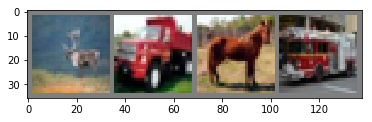

 deer truck horse truck


In [20]:
import matplotlib.pyplot  as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolution Neural Network ##

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = ConvNet()     
        

## Loss Function

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network ##

In [25]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.215
[1,  4000] loss: 1.887
[1,  6000] loss: 1.684
[1,  8000] loss: 1.594
[1, 10000] loss: 1.520
[1, 12000] loss: 1.456
[2,  2000] loss: 1.401
[2,  4000] loss: 1.357
[2,  6000] loss: 1.347
[2,  8000] loss: 1.312
[2, 10000] loss: 1.290
[2, 12000] loss: 1.279
Finished Training


## Test the network on test Data

In [ ]:
dataiter = iter(testloader)

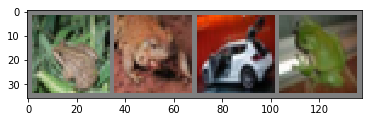

GroundTruth:   frog  frog   car  frog


In [36]:

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now we are going to see how the Network classifies these examples

In [37]:
outputs = net(images)
print(outputs)

tensor([[-2.6457, -1.9105,  1.4755,  1.9151,  3.5977,  0.9787,  4.1981,
         -0.8435, -4.0470, -3.3079],
        [-1.6982, -0.4709,  1.0381,  0.2993,  0.3018, -0.0863,  5.7619,
         -2.1872, -2.4764, -0.8733],
        [-0.6317,  2.6277,  1.9179,  0.0146, -2.4840, -0.0069,  1.3370,
         -2.8825, -2.6783, -0.2397],
        [-0.0392, -2.9948,  3.5533, -0.0333,  4.2680, -0.7261,  2.5154,
         -1.1275, -2.5426, -3.2119]])


As we can see this oputput is the energies for the 10 classes, we need to transform this vector into 1 vamue, the class with more energy.

In [38]:
_, predicted = torch.max(outputs, 1)

In [39]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  frog   car  deer


Let's look at the full test dataset 

In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


## Classes with good and poor performances

In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 58 %
Accuracy of  bird : 28 %
Accuracy of   cat : 29 %
Accuracy of  deer : 52 %
Accuracy of   dog : 45 %
Accuracy of  frog : 76 %
Accuracy of horse : 60 %
Accuracy of  ship : 46 %
Accuracy of truck : 80 %
